# Practice 2

Student 1: Alejandro González Álvarez

NIA 1: 252658

Student 2: Luca Franceschi

NIA 2: 253885

Student 3: Júlia Othats-Dalès

NIA 3: 254435

# Imports

In [34]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd

# Google Drive (or not)

In [7]:
# Comment if not in Google Colab
from google.colab import drive
drive.mount('/content/drive')

datadir = '/content/drive/My Drive/DeepLearning_2024/P2/Data/'
#datadir = 'Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# GPU Acceleration (or not)

In [5]:
# Print if gpu acceleration is enabled
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Ex.1 - Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs

In [ ]:
'''
Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs
Steps :
1. Load and visualize the training and testing data in 'data/P2_E1.csv' as shown in the following code cell.
2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:
  -   Adapt the classification loss and the SequenceClassifier module
  -   Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix
3. Experiment with different models by changing different hyper-parameters (e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.
4. Visualize analyse and discuss the results in the report.
'''

# Sol 1.

In [ ]:
# 1. Load and visualize the training and testing data
data = np.load(datadir+'P2_E1.npz')
X_train, X_test = data['X_train'], data['X_test']
Y_train, Y_test = data['Y_train'], data['Y_test']

print(f'Train Seqs: {X_train.shape}')
print(f'Train Labels: {Y_train.shape}')
print(f'Test Seqs: {X_test.shape}')
print(f'Test Labels: {Y_test.shape}')

classes = np.unique(Y_train)
n_classes = len(classes)
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

fig, axs = plt.subplots(n_classes, 1, figsize=(10, 5*n_classes))
for class_idx in range(0, n_classes):
  axs[class_idx].plot(X_test[Y_test == class_idx, :].T,'-o',
                      c=colors[class_idx])
  axs[class_idx].set_title(f'Tests Seqs. - Class {class_idx}')
fig.show()

In [29]:
# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters

class SequenceClassifier(nn.Module):
  def __init__(self,
               input_size : int = 1,
               hidden_size : int = 5,
               num_layers = 1,
               num_classes : int = 6,
               use_lstm : bool = False):
    # Define RNN or LSTM architecture
    super().__init__()
    self.use_lstm = use_lstm
    if(use_lstm):
      self.rnn =  nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                          num_layers=num_layers, batch_first = True)
    else:
      self.rnn =  nn.RNN(input_size = input_size, hidden_size = hidden_size,
                         num_layers=num_layers, batch_first = True)
    self.softmax = nn.Softmax(dim=1)
    self.last_linear = nn.Linear(hidden_size, num_classes)  # 6 is number of different classes

  def forward(self, X):
    _, last_states = self.rnn(X)
    # Get last hidden state for last layer. Ignore cell state in case of LSTMs
    if(not self.use_lstm):
      last_hidden_state = last_states[-1,:,:].squeeze(0)
    else:
      last_hidden_state = last_states[0][-1,:,:].squeeze(0)
    # Get sequence label probability using the last hidden state
    output = self.softmax(self.last_linear(last_hidden_state))  # Using softmax instead of sigmoid
    return output

In [32]:
# Define the training model
def train_multiclass_classifier(X_train, Y_train, classifier, optimizer, loss_func, epochs=100):
  loss_epochs = []
  for epoch in range(epochs):
      optimizer.zero_grad()
      output = classifier(X_train)
      loss = loss_func(output, Y_train)
      loss_epochs.append(loss.item())
      loss.backward()
      optimizer.step()
  print(f'Final loss: {loss.item()}')
  return np.asarray(loss_epochs)

# Adapt the test_sequence_classifier function
def test_multiclass_classifier(X_test, Y_test, classifier, prob_threshold=0.5):
  output = classifier(X_test)
  predicted_labels = torch.argmax(output, dim=1)
  correct_predictions = (predicted_labels == Y_test).sum().item()
  total_samples = len(Y_test)
  accuracy = correct_predictions / total_samples
  print(f'Test Accuracy: {accuracy:.4f}')
  return accuracy


In [33]:
X_train_pt = torch.from_numpy(X_train).float().unsqueeze(2).cuda()
Y_train_pt = torch.from_numpy(Y_train).long().cuda()
X_test_pt = torch.from_numpy(X_test).float().unsqueeze(2).cuda()
Y_test_pt = torch.from_numpy(Y_test).long().cuda()

loss_func = nn.CrossEntropyLoss()

exp_hidden_size = [1, 5]
exp_num_layers = [1, 2]
exp_use_lstm = [False, True]

losses_models = {}
test_accuracy_models = {}

for hidden_size, num_layers, use_lstm in zip(exp_hidden_size,exp_num_layers,exp_use_lstm):

  model_id = f'H{hidden_size}_NL{num_layers}_LSTM{int(use_lstm)}'
  print(f'Training: {model_id}')

  seq_classifier = SequenceClassifier(use_lstm=use_lstm, num_layers=num_layers, hidden_size=hidden_size)
  seq_classifier.cuda()

  optimizer = torch.optim.Adam(seq_classifier.parameters(), lr=1e-3)

  losses_models[model_id] = train_multiclass_classifier(X_train_pt, Y_train_pt,
                                                        seq_classifier, optimizer,
                                                        loss_func, epochs=1000)

  test_accuracy_models[model_id] = test_multiclass_classifier(X_test_pt, Y_test_pt, seq_classifier)

Training: H1_NL1_LSTM0
Final loss: 1.7791435718536377
Test Accuracy: 0.2000
Training: H5_NL2_LSTM1
Final loss: 1.4122083187103271
Test Accuracy: 0.5889


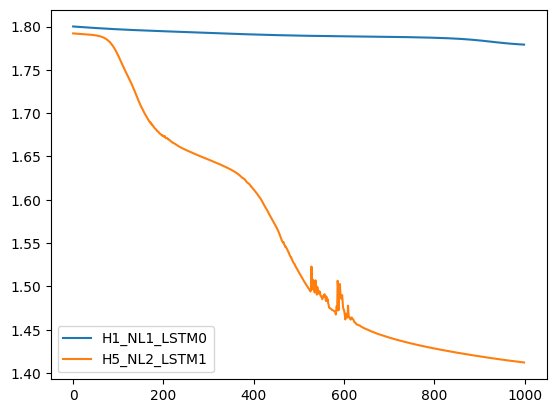

,H1_NL1_LSTM0,H5_NL2_LSTM1
accuracy %,20.0,58.888889


In [35]:
for loss_it in losses_models.values():
  plt.plot(loss_it)
plt.legend(losses_models.keys())
plt.show()

pd.DataFrame(np.asarray(list(test_accuracy_models.values()))*100, columns=['accuracy %'],
             index=test_accuracy_models.keys()).transpose()

Notes:
- Considerar usar un random_seed para quedarnos solo con los mejores resultados
- En este nos interesa guardar solo el ultimo estado ya que ese estado contiene a su vez los otros anteriores.

# Ex 2. Cryptoanalysis with corrupted messages using RNNs/LSTMs

In [ ]:
'''
Similar to the exercise solved on P2-examples, you have to solve time-series modelling based on Cryptanalysis.

For this exercise, you have training.pkl and testing_corrupted.pkl files.
These files contain a new encrypted dataset of 10000 sentences, 8000 for training and 2000 for the test.
Similar to the exercise solved in class, all the samples are encrypted using the Vigenère cipher with
7-length keyword. However, during the transmission of the test set, the encrypted data has been corrupted
with a new char ("-"), while the training set has been transmitted correctly.

Each 32-length sentence contains 4 corrupted chars randomly distributed on the test set, representing 12,5 % of total data.

Example:

Received Ciphertext:   'WCPS-VH-JHIKCUSETJV-AW-LPVUAHFHH'
Correct Ciphertext (Not provided):   'WCPSEVHAJHIKCUSETJVKAWGLPVUAHFHH'
Ground truth:   'HEWENTALLOUTANDGAVEITHISBESTSHOT'

Steps :
1. Discover the keyword used to encrypt the plaintext data. (hint: use Vigenère table and some samples)
2. Design/Implement an strategy to train the model so that it can be robust to missing characters in the testing samples ( to be discussed in class )
3. Train a sequential model to decode the corrupted test data.
4. Evaluate the decoding accuracy for the test set in terms of characters that were not corrupted or corrupted independently.
5. Try to improve the performance by applying some improvements over the model: stacked LSTMs,
hidden_sizes, embedding_size, optimizer, data augmentation during training, etc...
6. Visualize and discuss on the final results.
'''

In 2. being robust means getting at least 87.5% accuracy (all non corrupt chars).

For 3. we should have 2 losses, and 2 accuracies, 1 for normal chars, and 1 for corrupted chars. We should try to get 95% accuracy, 100% of the 87,5% correct chars and more or less 50% of corrupted chars are solved correctly.

Advice: do data augmentation/transformation to try to make the training data look more like the testing data.

# Sol 2.

## 1. Discover the keyword used to encrypt the plaintext data

In [10]:
# Load train and test files into memory
pkl_file = open(datadir+'train_vigenere.pkl', 'rb')
train = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(datadir+'testing_corrupted.pkl', 'rb')
test = pickle.load(pkl_file)
pkl_file.close()

vocabulary = [char for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'] # Predefined vocabulary

In [11]:
def int_to_vocabulary(message, vocabulary):
  decoded = ''
  for letter_code in message:
    decoded += vocabulary[letter_code]
  return decoded

In [12]:
keyword = (train[0][0]-train[0][1]) % len(vocabulary)
print(f'Train Message encrypted:       {int_to_vocabulary(train[0][0],vocabulary)}')
print( 'The keyword for en/decryption: {kw}'.format(kw=int_to_vocabulary(keyword, vocabulary)))
print(f'Train Message decrypted:       {int_to_vocabulary(train[0][1],vocabulary)}')
print('\nThe keyword (length {l}) is: {kw}'.format(l=6, kw=int_to_vocabulary(keyword, vocabulary)[:6]))

Train Message encrypted:       FHXMWFOELYIAMGKZUJQSLROBROKWIAUL
The keyword for en/decryption: MATRIXMATRIXMATRIXMATRIXMATRIXMA
Train Message decrypted:       THEVOICESHADAGRIMMESSAGEFORFADIL

The keyword (length 6) is: MATRIX


In [13]:
# LUCA: PONE EN EL ENUNCIADO QUE ES DE LENGTH 7 PERO MATRIX TIENE 6, ERROR DE ENUNCIADO?

## 2.Design/Implement an strategy to train the model

Proposed strategy: train as if there was another character in the vocabulary

Problems of this strategy: this character won't be trained properly

Solution to this problem: we could intentionally corrupt training data so the model learns how to interpret those appropiately

In [14]:
corr_vocab = [char for char in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ-'] # Corrupted vocabulary

In [15]:
class CorruptedDataset(Dataset):
    # the data is in the form [img_name, boundaries]
    def __init__(self, data, p=0.125, corrupted_char=26):
        self.data = data
        self.corr_prob = p
        self.corr_char = corrupted_char
        self.shape = data.shape
        self.batch_size = None

        def corrupt_tensor(tensor):
            corrupted_idx = np.random.uniform(size=tensor.shape[0]) < self.corr_prob
            corr_item = tensor.clone()
            corr_item[corrupted_idx==True] = self.corr_char
            return corr_item
        self.transform = corrupt_tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.transform(self.data[idx])

In [16]:
class DecrypterNetwork(nn.Module):
  def __init__(self,
               hidden_size : int = 8,
               num_layers = 1,
               num_letters = 26,
               letters_embedding_size : int = 8,
               use_lstm : bool = False):
    # Define RNN or LSTM architecture
    super().__init__()
    self.hidden_size = hidden_size
    self.num_letters = num_letters
    self.letters_embedder = torch.nn.Embedding(num_letters, letters_embedding_size)
    self.use_lstm = use_lstm
    self.softmax = nn.Softmax(dim=1)
    if(use_lstm):
      self.rnn =  nn.LSTM(input_size = letters_embedding_size, hidden_size = hidden_size,
                          num_layers=num_layers, batch_first = True)
    else:
      self.rnn =  nn.RNN(input_size = letters_embedding_size, hidden_size = hidden_size,
                         num_layers=num_layers, batch_first = True)
    self.last_linear = nn.Linear(hidden_size,num_letters)

  def forward(self, X):
    N = X.shape[0]
    L = X.shape[1]
    embedded_letters = self.letters_embedder(X)
    # Get hidden states for all letters in the sequence
    hidden_states,_ = self.rnn(embedded_letters)
    # In case of multiple input sequneces flat (N,L,hidden_size) to (N*L,hidden_size) for linear layer
    hidden_states_concat = hidden_states.reshape(-1,self.hidden_size)
    # Get letters probability using the hidden states for each position in the sequence
    letters_loggits = self.last_linear(hidden_states_concat)
    # Use soft-max over logits and reshape to format (N,L,num_letteres)
    letters_probs = self.softmax(letters_loggits).reshape(N,L,self.num_letters)
    return letters_probs

In [17]:
def train_test(model, num_epochs, loss_fn, optimizer,
               train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted):

    model = model.to(device)
    # train_encrypted_loader = train_encrypted_loader.data.to(device)
    train_decrypted = train_decrypted.to(device)
    test_encrypted = test_encrypted.to(device)
    test_decrypted = test_decrypted.to(device)

    loss_hist = []
    acc_hist = []
    test_loss_hist = []

    for epoch in range(num_epochs):
        # TRAINING AND BACK-PROPAGATION
        model.train()
        optimizer.zero_grad()
        letters_probs = model(next(iter(train_encrypted_loader)))
        loss = loss_fn(letters_probs.log().permute(0,2,1), # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
                      train_decrypted)
        loss.backward() # Backpropagate
        optimizer.step() # Update weights
        loss_hist.append(loss.item())

        # EVALUATION
        model.eval()
        letters_probs = model(test_encrypted)
        test_loss = loss_fn(letters_probs.log().permute(0,2,1), # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
                            test_decrypted)
        _,maxprob_letters_idx = letters_probs.max(dim=2) # get letter with maximum prob
        accuracy = ((maxprob_letters_idx==test_decrypted)*1.0).mean() # compute accuracy
        test_loss_hist.append(test_loss.item())
        acc_hist.append(accuracy.item())

        if(epoch%50==0):
          print(f'Epoch {epoch} \t Train Loss {round(loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(accuracy.item()*100,1)}')
    print(f'Final Epoch \t Train Loss {round(loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(accuracy.item()*100,1)}')
    return model,loss_hist, test_loss_hist, acc_hist

In [18]:
train_encrypted = torch.concat([train_sample[0].unsqueeze(0) for train_sample in train],dim=0)
train_decrypted = torch.concat([train_sample[1].unsqueeze(0) for train_sample in train],dim=0)
test_encrypted = torch.concat([test_sample[0].unsqueeze(0) for test_sample in test],dim=0)
test_decrypted = torch.concat([test_sample[1].unsqueeze(0) for test_sample in test],dim=0)

train_encrypted_dataset = CorruptedDataset(train_encrypted)
train_encrypted_loader = DataLoader(train_encrypted_dataset, batch_size=len(train_encrypted_dataset), shuffle=False)

decrypter_network = DecrypterNetwork(num_layers=2,
                                    num_letters=len(corr_vocab),
                                    hidden_size=16,
                                    use_lstm=True)

num_epochs=600
CE_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=1e-2)

In [20]:
decrypter_network, loss_hist, test_loss_hist, acc_hist = train_test(decrypter_network,
                                                 num_epochs,
                                                 CE_loss,
                                                 optimizer,
                                                 train_encrypted_loader, train_decrypted, test_encrypted, test_decrypted)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
plt.plot(loss_hist, '-.r', linewidth=1.0, label='train_loss')
plt.plot(test_loss_hist,'-b', linewidth=1.0, label='test_loss')
plt.xlabel('train step', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend()
plt.show()

plt.plot(acc_hist, linewidth=3.0, label='test_acc')
plt.xlabel('train step', fontsize=14)
plt.ylabel('accuracy(%)', fontsize=14)
plt.ylim([0, 1])
plt.xlim([0, num_epochs])
plt.legend()
plt.show()

decrypter_network = decrypter_network.to(device)
for idx_sample in range(0,10):
  # Inference over single training sequence
  letters_probs = decrypter_network(test[idx_sample][0].unsqueeze(0))
  # get index of letter with max probability
  _,maxprob_letters_idx = letters_probs.max(dim=2)
  print('--------------------------------------')
  print(f'Original Message encrypted: {int_to_vocabulary(test[idx_sample][0],corr_vocab)}')
  print(f'Message decrypted: {int_to_vocabulary(test[idx_sample][1],vocabulary)}')
  print(f'Prediction Message decrypted: {int_to_vocabulary(maxprob_letters_idx[0],corr_vocab)}')
  acc = (1.0*(maxprob_letters_idx[0]==test[idx_sample][1])).mean().item()
  print(f'Prediction Message Accuracy : {round(acc,2)}')